In [1]:
import pandas as pd
import tensorflow
import numpy as np 
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications.mobilenet_v2 import MobileNetV2

In [2]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [3]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))

In [4]:
data=pd.read_csv("C:/Users/karan/Desktop/skin-cancer/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [5]:
X.sample(5)

,image_full_name,dx,lesion_id
7223,ISIC_0025713.jpg,nv,HAM_0003178
9122,ISIC_0030663.jpg,nv,HAM_0006104
5006,ISIC_0028070.jpg,nv,HAM_0000989
5094,ISIC_0025077.jpg,nv,HAM_0003456
5844,ISIC_0031414.jpg,nv,HAM_0000400


In [6]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.17, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.17, random_state=42)

In [7]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train

In [9]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test

In [10]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.00) 

In [11]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory="C:/Users/karan/Desktop/skin-cancer/HAM1000_images",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [12]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)

In [13]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory="C:/Users/karan/Desktop/skin-cancer/HAM1000_images",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))

Found 1703 validated image filenames.


In [14]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory="C:/Users/karan/Desktop/skin-cancer/HAM1000_images",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [15]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [16]:
from keras.optimizers import adam_v2,gradient_descent_v2
sgd = gradient_descent_v2.SGD(learning_rate = 0.01, clipvalue = 0.5)
model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])

In [17]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=30,callbacks=[learning_control])

C:\Users\karan\.conda\envs\TF\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
215/215 [==============================] - 114s 493ms/step - loss: 1.0683 - accuracy: 0.6572 - val_loss: 2.4846 - val_accuracy: 0.6733
Epoch 2/30
215/215 [==============================] - 102s 475ms/step - loss: 0.8293 - accuracy: 0.7032 - val_loss: 2.6121 - val_accuracy: 0.6733
Epoch 3/30
215/215 [==============================] - 102s 472ms/step - loss: 0.7498 - accuracy: 0.7258 - val_loss: 3.0796 - val_accuracy: 0.6733
Epoch 4/30
215/215 [==============================] - 101s 471ms/step - loss: 0.6871 - accuracy: 0.7574 - val_loss: 2.4604 - val_accuracy: 0.6726

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 5/30
215/215 [==============================] - 101s 469ms/step - loss: 0.5964 - accuracy: 0.7850 - val_loss: 2.0767 - val_accuracy: 0.6733
Epoch 6/30
215/215 [==============================] - 102s 471ms/step - loss: 0.5487 - accuracy: 0.8053 - val_loss: 1.8006 - val_accuracy: 0.6747
Epoch 7/30
215/215 [========================

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          737344    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [19]:
model.save('model.h5')

C:\Users\karan\.conda\envs\TF\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


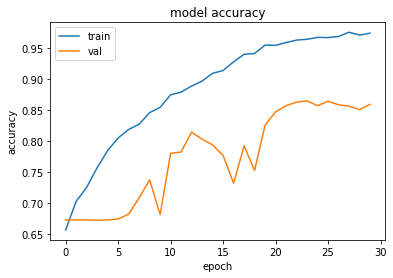

In [22]:
!pip install matplotlib
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

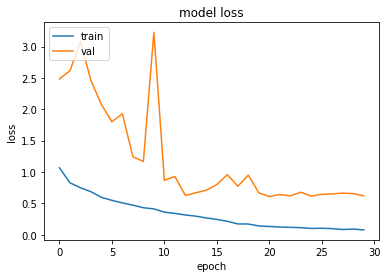

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

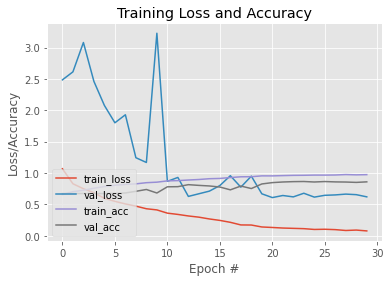

In [27]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [28]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

C:\Users\karan\.conda\envs\TF\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1703/1703 [==============================] - 30s 17ms/step


In [29]:
c=np.where(y_pred == name_as_indexes_test)
np.count_nonzero(c)
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 84.79154433352906


In [30]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(name_as_indexes_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.64      0.56      0.60        62
           1       0.67      0.82      0.74        77
           2       0.71      0.68      0.70       201
           3       0.56      0.38      0.45        24
           4       0.67      0.58      0.62       191
           5       0.92      0.95      0.94      1128
           6       0.85      0.85      0.85        20

    accuracy                           0.85      1703
   macro avg       0.72      0.69      0.70      1703
weighted avg       0.84      0.85      0.84      1703



In [31]:
model.save("model.h5")

C:\Users\karan\.conda\envs\TF\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [32]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________